# Цифровая обработка изображений

## Лабораторная работа №1 "Геометрические преобразования изображений"

Выполнила студентка группы 8303 Самойлова Анна

In [1]:
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np

loading_filename - путь к входному изображению в формате bmp, jpg  
result_filename - путь к выходнаму изображению в формате bmp  
alpha - угол поворота изображения от 0 до 360  
k - коэффициент от 0 до 1  
iterpolation_scheme_sign - признак используемой интерполяционной схемы:
* 0 – нулевого порядка 
* 1 – первого порядка 
* 2- третьего порядка

In [2]:
loading_filename = 'picture.jpg'
result_filename = 'result.bmp'
alpha = 30
k = 0.5
iterpolation_scheme_sign = 1

In [3]:
def show_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

In [4]:
def rotate_image(image, angle):
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)
    
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )
    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5
    
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))
    
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result

In [5]:
def largest_rotated_rect(w, h, angle):
    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )

In [6]:
def crop_around_center(image, width, height):

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]

### Входное изображение

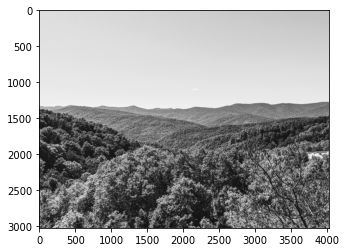

In [7]:
image = cv2.imread(loading_filename)
show_image(image)

### Повернутое изображение

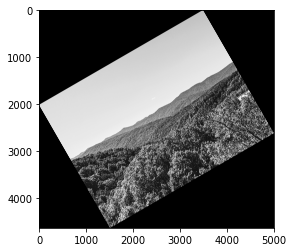

In [8]:
image_height, image_width = image.shape[0:2]

image_orig = np.copy(image)
image_rotated = rotate_image(image, alpha)
show_image(image_rotated)

### Прямоугольник максимальной площади

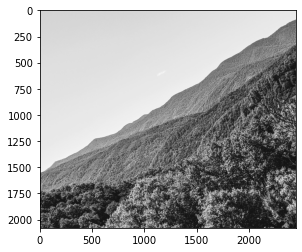

In [9]:
image_rotated_cropped = crop_around_center(
    image_rotated,
    *largest_rotated_rect(
        image_width,
        image_height,
        math.radians(alpha)
    )
)
show_image(image_rotated_cropped)

### Увеличение по оси Y и уменьшение по оси X в k раз

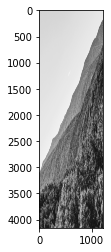

In [10]:
(h, w) = image_rotated_cropped.shape[:2]
down_points = (int(w * k), int(h / k))
if iterpolation_scheme_sign == 0:
    resized_image_rotated_cropped = cv2.resize(image_rotated_cropped, down_points, interpolation=cv2.INTER_NEAREST)
elif iterpolation_scheme_sign == 1:
    resized_image_rotated_cropped = cv2.resize(image_rotated_cropped, down_points, interpolation=cv2.INTER_LINEAR)
elif iterpolation_scheme_sign == 2:
    resized_image_rotated_cropped = cv2.resize(image_rotated_cropped, down_points, interpolation=cv2.INTER_AREA)
show_image(resized_image_rotated_cropped)

In [11]:
cv2.imwrite(result_filename, resized_image_rotated_cropped)

True